### 集成交易模型
1. 数据收集：所有A股。
2. 数据清洗：清除不适当的股票，如ST、ST*等。
3. 标签制作：在T到T + 11之间的VWAP ROI。
4. 数据预处理：3MAD、z-score等。
5. ROI数据框制作：HS300、CS500、CS1000等。
6. 建模：MLP、GBDT、AGRU。
7. 集成：根据过去60天的ICIR。
8. 回测。

In [2]:
# Modeling
import tensorflow as tf
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
from sklearn.preprocessing import StandardScaler

import xgboost as xgb

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Attention, Layer, GRU, Input, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler

from math import sqrt
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from datetime import date, timedelta

from cylib.apis.all_api import *

# 清除warning
warnings.filterwarnings('ignore', category=pd.core.common.SettingWithCopyWarning)

zscore = StandardScaler()

### 去除不合适的股票

In [4]:
# Remove inappropriate stocks.
begin_date = "20180101"
end_date = "20240329"

all_stocks = get_targets_info(target_type='stock')
all_stocks = all_stocks[["ts_code", "name", "list_date", "list_board_name"]]
all_stocks = all_stocks.dropna()
all_stocks['list_date'] = pd.to_datetime(all_stocks['list_date'])
all_stocks = all_stocks[all_stocks['list_date'] <= pd.to_datetime(begin_date)] # 去除开始日期之后上市的股票
all_stocks = all_stocks[all_stocks['ts_code'].str[0] != 'A'] # 去除非A股股票
all_stocks= all_stocks[all_stocks['list_board_name'] != '北证']
all_stocks = all_stocks[~all_stocks['name'].str.endswith("(IPO终止)")]
all_stocks = all_stocks[~all_stocks['name'].str.endswith("(退市)")] # 去除退市股票
all_stocks = all_stocks[~all_stocks['name'].str.startswith('ST')] # 去除 ST
all_stocks = all_stocks[~all_stocks['name'].str.startswith('*ST')] # 去除 *ST

stocks_code = list(all_stocks['ts_code'])
# stocks_code

In [5]:
len(stocks_code)

3219

### 交易日期
- 训练日期
- 测试日期
- 回测日期
- 剔除日期：没有标签的股票的日期
- GRU（AGRU）日期：用于GRU（AGRU）模型的日期

In [14]:
# 获取交易日期
PRICE = get_price(
    ts_code_list=stocks_code,
    feature_list=["open"],
    start_date=begin_date,
    trade_date=end_date,
    target_type="stock",
)
PRICE.reset_index(inplace=True)
PRICE = PRICE.sort_values(by='trade_date').reset_index(drop=True)
PRICE_pivot = PRICE.fillna(0)
PRICE_pivot = PRICE_pivot.pivot(index="trade_date", columns="ts_code", values="open")

# 注意: len(date_all) >= 60，这样才能保证有测试集
date_all = PRICE_pivot.index
date_train, date_backtest = train_test_split(date_all, test_size=0.2, shuffle=False)
date_test = date_backtest[:-11]
date_drop = date_backtest[-11:] # 剔除日期
date_GRU = date_all[29:]

# 寻找有缺失值的股票
all_combinations = pd.MultiIndex.from_product([date_all, stocks_code], names=['trade_date', 'ts_code'])
all_combinations_df = pd.DataFrame(index=all_combinations).reset_index()
price_whole = pd.merge(all_combinations_df, PRICE, on=['trade_date', 'ts_code'], how='left') # 左连接
missing = price_whole[price_whole.isnull().any(axis=1)]
missing_stock = missing['ts_code'].unique()
print("The missing stock:", missing_stock)

# 去除有缺失值的股票
mask = all_stocks['ts_code'].isin(missing_stock)
all_stocks = all_stocks[~mask]
stocks_code = list(all_stocks['ts_code'])

# 删除变量，释放内存
del PRICE, PRICE_pivot, all_combinations, all_combinations_df, \
    price_whole, missing, missing_stock

The missing stock: ['000629.SZ' '000950.SZ' '000995.SZ' '600610.SH' '000670.SZ' '000792.SZ']


In [8]:
print(date_train)

DatetimeIndex(['2018-01-02', '2018-01-03', '2018-01-04', '2018-01-05',
               '2018-01-08', '2018-01-09', '2018-01-10', '2018-01-11',
               '2018-01-12', '2018-01-15',
               ...
               '2022-12-14', '2022-12-15', '2022-12-16', '2022-12-19',
               '2022-12-20', '2022-12-21', '2022-12-22', '2022-12-23',
               '2022-12-26', '2022-12-27'],
              dtype='datetime64[ns]', name='trade_date', length=1212, freq=None)


In [9]:
print(date_test)

DatetimeIndex(['2022-12-28', '2022-12-29', '2022-12-30', '2023-01-03',
               '2023-01-04', '2023-01-05', '2023-01-06', '2023-01-09',
               '2023-01-10', '2023-01-11',
               ...
               '2024-03-01', '2024-03-04', '2024-03-05', '2024-03-06',
               '2024-03-07', '2024-03-08', '2024-03-11', '2024-03-12',
               '2024-03-13', '2024-03-14'],
              dtype='datetime64[ns]', name='trade_date', length=292, freq=None)


In [10]:
print(date_backtest)

DatetimeIndex(['2022-12-28', '2022-12-29', '2022-12-30', '2023-01-03',
               '2023-01-04', '2023-01-05', '2023-01-06', '2023-01-09',
               '2023-01-10', '2023-01-11',
               ...
               '2024-03-18', '2024-03-19', '2024-03-20', '2024-03-21',
               '2024-03-22', '2024-03-25', '2024-03-26', '2024-03-27',
               '2024-03-28', '2024-03-29'],
              dtype='datetime64[ns]', name='trade_date', length=303, freq=None)


In [11]:
print(date_drop)

DatetimeIndex(['2024-03-15', '2024-03-18', '2024-03-19', '2024-03-20',
               '2024-03-21', '2024-03-22', '2024-03-25', '2024-03-26',
               '2024-03-27', '2024-03-28', '2024-03-29'],
              dtype='datetime64[ns]', name='trade_date', freq=None)


In [12]:
print(date_GRU)

DatetimeIndex(['2018-02-12', '2018-02-13', '2018-02-14', '2018-02-22',
               '2018-02-23', '2018-02-26', '2018-02-27', '2018-02-28',
               '2018-03-01', '2018-03-02',
               ...
               '2024-03-18', '2024-03-19', '2024-03-20', '2024-03-21',
               '2024-03-22', '2024-03-25', '2024-03-26', '2024-03-27',
               '2024-03-28', '2024-03-29'],
              dtype='datetime64[ns]', name='trade_date', length=1486, freq=None)


### 获取股票

In [13]:
# Get stocks
price = get_price(
    ts_code_list=stocks_code,
    feature_list=[
        "open",
        "high",
        "low",
        "close",
        "avg_price",
        "volume",
        "trade_status", # "交易"/"停牌"
    ],
    start_date=begin_date,
    trade_date=end_date,
    target_type="stock",
)
price = price.rename(columns={'open': 'OPEN',
                              'high': 'HIGH',
                              'low': 'LOW',
                              'close': 'CLOSE',
                              'avg_price': 'VWAP',
                              'volume': 'VOLUME'})
price.reset_index(inplace=True)
indexes = ['OPEN', 'HIGH', 'LOW', 'CLOSE', 'VWAP', 'VOLUME']
price = price.sort_values(by='trade_date').reset_index(drop=True)
price.fillna(0, inplace=True)
price

,trade_date,ts_code,OPEN,HIGH,LOW,CLOSE,VWAP,VOLUME,trade_status
0,2018-01-02,000001.SZ,13.35,13.93,13.32,13.70,13.7229,2081590.0,交易
1,2018-01-02,002156.SZ,13.25,13.47,13.04,13.42,13.2816,259075.0,交易
2,2018-01-02,601117.SH,6.76,6.99,6.73,6.99,6.9384,566047.0,交易
3,2018-01-02,002155.SZ,9.77,9.78,9.63,9.70,9.6832,178833.0,交易
4,2018-01-02,601118.SH,5.56,5.65,5.54,5.65,5.6005,185770.0,交易
...,...,...,...,...,...,...,...,...,...
4867690,2024-03-29,300489.SZ,17.73,18.45,17.23,18.30,17.9723,65574.9,交易
4867691,2024-03-29,603990.SH,10.99,11.18,10.72,10.86,10.8675,67429.2,交易
4867692,2024-03-29,300289.SZ,4.75,4.82,4.70,4.81,4.7632,60659.0,交易
4867693,2024-03-29,600889.SH,4.39,4.56,4.39,4.51,4.4948,166136.0,交易


### 获取基准指标

In [21]:
# Get benchmark index
# 1. 上证指数(the HS 300 index)(000300)
# 2. 中证500(000905)
# 3. 中证1000(000852)
benchmark = get_price(
    ts_code_list=["000300.SH", "000905.SH", "000852.SH"],
    feature_list=[
        "open",
        "high",
        "low",
        "close",
        "volume"
    ],
    start_date=begin_date,
    trade_date=end_date,
    target_type="index",
)
benchmark = benchmark.rename(
    columns={
        "open": "OPEN",
        "high": "HIGH",
        "low": "LOW",
        "close": "CLOSE",
        "volume": 'VOLUME'
    }
)
benchmark.reset_index(inplace=True)
benchmark = benchmark.sort_values(by="trade_date").reset_index(drop=True)
benchmark.fillna(0, inplace=True)
benchmark

,trade_date,ts_code,OPEN,HIGH,LOW,CLOSE,VOLUME
0,2018-01-02,000300.SH,4045.21,4087.78,4045.21,4087.40,146935000.0
1,2018-01-02,000905.SH,6263.15,6332.61,6258.16,6332.23,73032200.0
2,2018-01-02,000852.SH,7027.63,7092.22,7022.23,7092.09,77191000.0
3,2018-01-03,000300.SH,4091.46,4140.05,4088.73,4111.39,151852000.0
4,2018-01-03,000905.SH,6331.72,6391.98,6324.26,6388.25,83936700.0
...,...,...,...,...,...,...,...
4537,2024-03-28,000905.SH,5156.48,5276.64,5156.48,5223.81,116318000.0
4538,2024-03-28,000852.SH,5262.22,5430.77,5262.22,5382.24,178599000.0
4539,2024-03-29,000300.SH,3516.88,3538.24,3516.88,3537.48,128643000.0
4540,2024-03-29,000852.SH,5383.74,5441.26,5345.87,5441.26,168653000.0


### 计算每日收益率
$ \textcolor{red}{收益率计算方式：收盘价相对于开盘价的变化率} $

In [23]:
BUY_price = price.pivot(index='trade_date', columns='ts_code', values='OPEN')
BUY_benchmark = benchmark.pivot(index='trade_date', columns='ts_code', values='OPEN')
SELL_price = price.pivot(index='trade_date', columns='ts_code', values='CLOSE')
SELL_benchmark = benchmark.pivot(index='trade_date', columns='ts_code', values='CLOSE')
price_return = (SELL_price - BUY_price) / BUY_price
benchmark_return = (SELL_benchmark - BUY_benchmark) / BUY_benchmark

del BUY_price, BUY_benchmark, SELL_price, SELL_benchmark

In [8]:
HS_300 = pd.DataFrame(benchmark_return['000300.SH'])
CS_500 = pd.DataFrame(benchmark_return['000905.SH'])
CS_1000 = pd.DataFrame(benchmark_return['000852.SH'])

### 计算label值

In [27]:
VWAP_df = price.pivot(index='trade_date', columns='ts_code', values='VWAP')

# T+1 到 T+11 收益率
T_begin = 1
T_end = 11
Label_df = (VWAP_df.shift(-T_end) - VWAP_df.shift(-T_begin)) / VWAP_df.shift(-T_begin)
# 注意：zscore.fit_transform() 是逐列计算的，因此我们使用 Label_df.T
Label_df_processed = pd.DataFrame(zscore.fit_transform(Label_df.T).T,
                                  index=Label_df.index,
                                  columns=Label_df.columns)

# 创建一个trade_date映射到label值的字典
label_dict = Label_df.to_dict(orient='index')
label_dict_processed = Label_df_processed.to_dict(orient='index')

# 定义一个函数来获取给定行（交易日期和股票代码）的标签值
def get_label(row):
    return label_dict[row['trade_date']][row['ts_code']]
def get_label_processed(row):
    return label_dict_processed[row['trade_date']][row['ts_code']]

# 将该函数应用于'price'数据框，创建一个新的'Label'列
Label_column = price.apply(get_label, axis=1)
price['Label'] = Label_column
Label_column_processed = price.apply(get_label_processed, axis=1)

del VWAP_df, Label_df, label_dict, label_dict_processed

/home/user/anaconda3/envs/juphub/lib/python3.8/site-packages/sklearn/utils/extmath.py:1051: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/home/user/anaconda3/envs/juphub/lib/python3.8/site-packages/sklearn/utils/extmath.py:1056: RuntimeWarning: invalid value encountered in true_divide
  T = new_sum / new_sample_count
/home/user/anaconda3/envs/juphub/lib/python3.8/site-packages/sklearn/utils/extmath.py:1076: RuntimeWarning: invalid value encountered in true_divide
  new_unnormalized_variance -= correction**2 / new_sample_count


### 数据预处理

In [29]:
def value_mapping(row):
    global value_dict
    return value_dict[row['trade_date']][row['ts_code']]

# 3MAD 
def Col_3MAD(row):
    median = row.median() # 中位数
    mad = abs(row - row.median()).median()
    threshold = 3 * mad
    lower_bound = median - threshold
    upper_bound = median + threshold
    return row.clip(lower=lower_bound, upper=upper_bound)

indexes = ['OPEN', 'HIGH', 'LOW', 'CLOSE', 'VWAP', 'VOLUME']
for index in indexes:
    df = price.pivot(index='trade_date', columns='ts_code', values=index)
    values = df.values
    # 每一行都标准化
    df = pd.DataFrame(zscore.fit_transform(values.T).T,
                      index=df.index,
                      columns=df.columns)
    df = df.apply(Col_3MAD, axis=1) # 每一行都使用3MAD
    value_dict = df.to_dict(orient='index')
    price[index + '_processed'] = price.apply(value_mapping, axis=1)
price['Label_processed'] = Label_column_processed
del Label_column, Label_column_processed
price.fillna(0, inplace=True)
price

,trade_date,ts_code,OPEN,HIGH,LOW,CLOSE,VWAP,VOLUME,trade_status,Label,OPEN_processed,HIGH_processed,LOW_processed,CLOSE_processed,VWAP_processed,VOLUME_processed,Label_processed
0,2018-01-02,000001.SZ,13.35,13.93,13.32,13.70,13.7229,2081590.0,交易,0.071596,-0.236671,-0.220110,-0.232050,-0.225132,-0.221635,0.003977,1.026957
1,2018-01-02,002156.SZ,13.25,13.47,13.04,13.42,13.2816,259075.0,交易,-0.127945,-0.241424,-0.241654,-0.245593,-0.238394,-0.242627,0.003977,-1.276479
2,2018-01-02,601117.SH,6.76,6.99,6.73,6.99,6.9384,566047.0,交易,0.058340,-0.549858,-0.545143,-0.550806,-0.542936,-0.544361,0.003977,0.873930
3,2018-01-02,002155.SZ,9.77,9.78,9.63,9.70,9.6832,178833.0,交易,0.002949,-0.406809,-0.414474,-0.410534,-0.414583,-0.413796,0.003977,0.234517
4,2018-01-02,601118.SH,5.56,5.65,5.54,5.65,5.6005,185770.0,交易,0.084621,-0.606888,-0.607901,-0.608366,-0.606402,-0.608003,0.003977,1.177318
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4867690,2024-03-29,300489.SZ,17.73,18.45,17.23,18.30,17.9723,65574.9,交易,0.000000,0.133027,0.144692,0.124923,0.145905,0.138854,-0.432936,0.000000
4867691,2024-03-29,603990.SH,10.99,11.18,10.72,10.86,10.8675,67429.2,交易,0.000000,-0.063079,-0.065240,-0.065712,-0.070461,-0.068017,-0.427285,0.000000
4867692,2024-03-29,300289.SZ,4.75,4.82,4.70,4.81,4.7632,60659.0,交易,0.000000,-0.244637,-0.248895,-0.241998,-0.246403,-0.245756,-0.447916,0.000000
4867693,2024-03-29,600889.SH,4.39,4.56,4.39,4.51,4.4948,166136.0,交易,0.000000,-0.255112,-0.256403,-0.251076,-0.255128,-0.253571,-0.126501,0.000000


In [11]:
price.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4867695 entries, 0 to 4867694
Data columns (total 17 columns):
 #   Column            Dtype         
---  ------            -----         
 0   trade_date        datetime64[ns]
 1   ts_code           object        
 2   OPEN              float64       
 3   HIGH              float64       
 4   LOW               float64       
 5   CLOSE             float64       
 6   VWAP              float64       
 7   VOLUME            float64       
 8   trade_status      object        
 9   Label             float64       
 10  OPEN_processed    float64       
 11  HIGH_processed    float64       
 12  LOW_processed     float64       
 13  CLOSE_processed   float64       
 14  VWAP_processed    float64       
 15  VOLUME_processed  float64       
 16  Label_processed   float64       
dtypes: datetime64[ns](1), float64(14), object(2)
memory usage: 631.3+ MB


### 数据拆分
训练集、测试集

In [15]:
# 训练集
price_train = price.loc[price["trade_date"].isin(date_train), :]
date_stock = ["trade_date", "ts_code"]
X_indexes = [
    "OPEN_processed",
    "HIGH_processed",
    "LOW_processed",
    "CLOSE_processed",
    "VWAP_processed",
    "VOLUME_processed",
]
y_index = "Label_processed"
price_X_train = price_train[X_indexes].values
price_y_train = price_train[y_index].values
del price_train

In [18]:
# 测试集
price_test = price.loc[price['trade_date'].isin(date_test), :]
price_X_test = price_test[X_indexes].values
price_y_test = price_test[y_index].values
del price_test

In [19]:
# 剔除日期股票数据集
price_drop = price.loc[price['trade_date'].isin(date_drop), :]
price_X_drop = price_drop[X_indexes].values
price_y_drop = price_drop[y_index].values
del price_drop

In [20]:
# 回测日期股票数据集
price_X_backtest = np.concatenate((price_X_test, price_X_drop), axis=0)

In [21]:
# 所有日期股票数据集
price_X_all = price[X_indexes].values
price_y_all = price[y_index].values

In [23]:
price

,trade_date,ts_code,OPEN,HIGH,LOW,CLOSE,VWAP,VOLUME,trade_status,Label,OPEN_processed,HIGH_processed,LOW_processed,CLOSE_processed,VWAP_processed,VOLUME_processed,Label_processed
0,2018-01-02,000001.SZ,13.35,13.93,13.32,13.70,13.7229,2081590.0,交易,0.071596,-0.236671,-0.220110,-0.232050,-0.225132,-0.221635,0.003977,1.026957
1,2018-01-02,002156.SZ,13.25,13.47,13.04,13.42,13.2816,259075.0,交易,-0.127945,-0.241424,-0.241654,-0.245593,-0.238394,-0.242627,0.003977,-1.276479
2,2018-01-02,601117.SH,6.76,6.99,6.73,6.99,6.9384,566047.0,交易,0.058340,-0.549858,-0.545143,-0.550806,-0.542936,-0.544361,0.003977,0.873930
3,2018-01-02,002155.SZ,9.77,9.78,9.63,9.70,9.6832,178833.0,交易,0.002949,-0.406809,-0.414474,-0.410534,-0.414583,-0.413796,0.003977,0.234517
4,2018-01-02,601118.SH,5.56,5.65,5.54,5.65,5.6005,185770.0,交易,0.084621,-0.606888,-0.607901,-0.608366,-0.606402,-0.608003,0.003977,1.177318
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4867690,2024-03-29,300489.SZ,17.73,18.45,17.23,18.30,17.9723,65574.9,交易,0.000000,0.133027,0.144692,0.124923,0.145905,0.138854,-0.432936,0.000000
4867691,2024-03-29,603990.SH,10.99,11.18,10.72,10.86,10.8675,67429.2,交易,0.000000,-0.063079,-0.065240,-0.065712,-0.070461,-0.068017,-0.427285,0.000000
4867692,2024-03-29,300289.SZ,4.75,4.82,4.70,4.81,4.7632,60659.0,交易,0.000000,-0.244637,-0.248895,-0.241998,-0.246403,-0.245756,-0.447916,0.000000
4867693,2024-03-29,600889.SH,4.39,4.56,4.39,4.51,4.4948,166136.0,交易,0.000000,-0.255112,-0.256403,-0.251076,-0.255128,-0.253571,-0.126501,0.000000


### 模型训练

##### MLP

In [45]:
# Define the MLP model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.05),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.05),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.05),
    tf.keras.layers.Dense(1)
])

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(optimizer=optimizer, loss='mean_squared_error')

# Train the model
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='loss', patience=50, restore_best_weights=True
)
history = model.fit(
    price_X_train, price_y_train,
    epochs=1000,
    callbacks=[early_stopping],
    batch_size=len(price_X_train)  # batch值为训练集长度
)

# Evaluate the model
y_pred_MLP_backtest = model.predict(price_X_backtest)
y_pred_MLP_all = model.predict(price_X_all)
mse_MLP_train = mean_squared_error(price_y_train, model.predict(price_X_train))
mse_MLP_test = mean_squared_error(price_y_test, model.predict(price_X_test))

print(f'MLP MSE(train): {mse_MLP_train}')
print(f'MLP MSE(test): {mse_MLP_test}')
# MLP MSE(train): 0.9924953226659671
# MLP MSE(test): 0.9949950036401641

Epoch 1/1000
1/1 [==============================] - 12s 12s/step - loss: 1.0007
Epoch 2/1000
1/1 [==============================] - 11s 11s/step - loss: 0.9990
Epoch 3/1000
1/1 [==============================] - 10s 10s/step - loss: 0.9987
Epoch 4/1000
1/1 [==============================] - 14s 14s/step - loss: 0.9980
Epoch 5/1000
1/1 [==============================] - 10s 10s/step - loss: 0.9979
Epoch 6/1000
1/1 [==============================] - 10s 10s/step - loss: 0.9980
Epoch 7/1000
1/1 [==============================] - 10s 10s/step - loss: 0.9979
Epoch 8/1000
1/1 [==============================] - 10s 10s/step - loss: 0.9975
Epoch 9/1000
1/1 [==============================] - 10s 10s/step - loss: 0.9974
Epoch 10/1000
1/1 [==============================] - 10s 10s/step - loss: 0.9974
Epoch 11/1000
1/1 [==============================] - 10s 10s/step - loss: 0.9974
Epoch 12/1000
1/1 [==============================] - 10s 10s/step - loss: 0.9973
Epoch 13/1000
1/1 [==================

##### GBDT(XGboost)

In [26]:
params = {
    'learning_rate': 0.01,
    'max_depth': 64,
    'max_leaves': 512,
    'min_child_weight': 512,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'reg:squarederror'
}

dtrain = xgb.DMatrix(price_X_train, label=price_y_train)
dtest = xgb.DMatrix(price_X_test, label=price_y_test)
dbacktest = xgb.DMatrix(price_X_backtest)
dall = xgb.DMatrix(price_X_all)

evals = [(dtest, 'eval'), (dtrain, 'train')]
num_round = 1000
bst = xgb.train(params, dtrain, 
                num_round, evals, 
                early_stopping_rounds=50, 
                verbose_eval=True)

y_pred_GBDT_backtest = bst.predict(dbacktest)
y_pred_GBDT_all = bst.predict(dall)
mse_GBDT_train = mean_squared_error(price_y_train, bst.predict(dtrain))
mse_GBDT_test = mean_squared_error(price_y_test, bst.predict(dtest))

print(f'GBDT MSE(train): {mse_GBDT_train}')
print(f'GBDT MSE(test): {mse_GBDT_test}')
# GBDT MSE(train): 0.9476405621114625
# GBDT MSE(test): 1.002617615102808

/home/user/anaconda3/envs/juphub/lib/python3.8/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[0]	eval-rmse:1.11585	train-rmse:1.11567
[1]	eval-rmse:1.11370	train-rmse:1.11335
[2]	eval-rmse:1.11158	train-rmse:1.11107
[3]	eval-rmse:1.10942	train-rmse:1.10881
[4]	eval-rmse:1.10730	train-rmse:1.10658
[5]	eval-rmse:1.10531	train-rmse:1.10442
[6]	eval-rmse:1.10328	train-rmse:1.10228
[7]	eval-rmse:1.10134	train-rmse:1.10018
[8]	eval-rmse:1.09937	train-rmse:1.09811
[9]	eval-rmse:1.09751	train-rmse:1.09610
[10]	eval-rmse:1.09561	train-rmse:1.09409
[11]	eval-rmse:1.09380	train-rmse:1.09214
[12]	eval-rmse:1.09197	train-rmse:1.09021
[13]	eval-rmse:1.09023	train-rmse:1.08833
[14]	eval-rmse:1.08848	train-rmse:1.08647
[15]	eval-rmse:1.08675	train-rmse:1.08464
[16]	eval-rmse:1.08505	train-rmse:1.08284
[17]	eval-rmse:1.08344	train-rmse:1.08109
[18]	eval-rmse:1.08187	train-rmse:1.07937
[19]	eval-rmse:1.08033	train-rmse:1.07768
[20]	eval-rmse:1.07874	train-rmse:1.07600
[21]	eval-rmse:1.07718	train-rmse:1.07436
[22]	eval-rmse:1.07566	train-rmse:1.07274
[23]	eval-rmse:1.07418	train-rmse:1.07116
[2

##### AGRU

##### 生成序列

In [29]:
from tqdm import tqdm # 进度条

def create_sequences(df, sequence_length, begin_index, end_index):
    '''
    sequence_length：整个序列中的时间步数。在本文中，序列长度 = 30。

    type：'train' 或 'test'

    begin_index：第一个序列的索引
    end_index：最后一个序列的索引
    '''
    sequences = []
    labels = []
    for stock in tqdm(df["ts_code"].unique(), desc="Stocks Progress", ncols=100):
        # 单个股票的数据
        stock_df = df[df["ts_code"] == stock].reset_index(drop=True)
        for i in range(sequence_length + begin_index, end_index + 2):
            seq = stock_df.iloc[i - sequence_length : i][
                ["OPEN_processed", 
                 "HIGH_processed", 
                 "LOW_processed", 
                 "CLOSE_processed", 
                 "VWAP_processed",
                 "VOLUME_processed"]].values
            label = stock_df.iloc[i - 1]['Label_processed']
            sequences.append(seq)
            labels.append(label)
    return np.array(sequences), np.array(labels)

# 设置序列长度为30
sequence_length = 30

# 训练集
train_X, train_y = create_sequences(price, 
                                    sequence_length, 
                                    0, 
                                    len(date_train) - 1)
# 测试集
test_X, test_y = create_sequences(price, 
                                  sequence_length, 
                                  len(date_train) - sequence_length + 1,
                                  len(date_train) + len(date_test) - 1)
# 剔除的股票数据集，回测股票数据集 = 测试集 + 剔除的股票数据集
drop_X, drop_y = create_sequences(price,
                                  sequence_length,
                                  len(date_train) + len(date_test) - sequence_length + 1,
                                  len(date_all) - 1)

Stocks Progress: 100%|██████████████████████████████████████████| 3213/3213 [14:57<00:00,  3.58it/s]


In [30]:
print(train_X.shape)
print(test_X.shape)
print(drop_X.shape)

(3800979, 30, 6)
(938196, 30, 6)
(35343, 30, 6)


In [33]:
# 定义AGRU模型
inputs = Input(shape=(30, 6))
gru = GRU(units=6, return_sequences=True)(inputs)
att = Attention()([gru, gru])
gru = GRU(units=6)(att)
outputs = Dense(1)(gru)

model = Model(inputs=inputs, outputs=outputs)

# 编译模型
model.compile(optimizer=Adam(learning_rate=1e-3), loss="mean_squared_error")

# 定义早停
early_stopping = EarlyStopping(
    monitor="loss", patience=20, restore_best_weights=True
)

history = model.fit(
    train_X,
    train_y,
    epochs=200,
    batch_size=1986,
    validation_data=(test_X, test_y),
    callbacks=[early_stopping],
)

loss = model.evaluate(test_X, test_y)
print("Model trained with loss:", loss)

2024-03-30 23:17:43.279400: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2736704880 exceeds 10% of free system memory.


Epoch 1/200


2024-03-30 23:17:51.447163: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:693] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "101" frequency: 2100 num_cores: 88 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 1048576 l3_cache_size: 31719424 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


1914/1914 [==============================] - ETA: 0s - loss: 1.0002

2024-03-30 23:19:54.744956: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 675501120 exceeds 10% of free system memory.
2024-03-30 23:19:55.709012: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:693] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "101" frequency: 2100 num_cores: 88 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 1048576 l3_cache_size: 31719424 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


1914/1914 [==============================] - 143s 72ms/step - loss: 1.0002 - val_loss: 0.9978
Epoch 2/200
1914/1914 [==============================] - 133s 69ms/step - loss: 0.9981 - val_loss: 0.9960
Epoch 3/200
1914/1914 [==============================] - 131s 69ms/step - loss: 0.9978 - val_loss: 0.9960
Epoch 4/200
1914/1914 [==============================] - 132s 69ms/step - loss: 0.9973 - val_loss: 0.9970
Epoch 5/200
1914/1914 [==============================] - 130s 68ms/step - loss: 0.9967 - val_loss: 0.9958
Epoch 6/200
1914/1914 [==============================] - 131s 68ms/step - loss: 0.9962 - val_loss: 0.9938
Epoch 7/200
1914/1914 [==============================] - 131s 68ms/step - loss: 0.9958 - val_loss: 0.9965
Epoch 8/200
1914/1914 [==============================] - 130s 68ms/step - loss: 0.9953 - val_loss: 0.9956
Epoch 9/200
1914/1914 [==============================] - 130s 68ms/step - loss: 0.9950 - val_loss: 0.9953
Epoch 10/200
1914/1914 [==============================] - 

2024-03-31 06:31:06.631789: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 675501120 exceeds 10% of free system memory.


29319/29319 [==============================] - 162s 6ms/step - loss: 0.9960
Model trained with loss: 0.9960154891014099


In [34]:
# 评估模型在测试集上的效果
y_pred_AGRU_train = model.predict(train_X)
y_pred_AGRU_test = model.predict(test_X)
y_pred_AGRU_drop = model.predict(drop_X)
y_pred_AGRU_backtest = np.concatenate((y_pred_AGRU_test.reshape(-1), 
                                       y_pred_AGRU_drop.reshape(-1)))
y_pred_AGRU_all = np.concatenate((y_pred_AGRU_train.reshape(-1), 
                                  y_pred_AGRU_backtest.reshape(-1)))
mse_AGRU_train = mean_squared_error(train_y, y_pred_AGRU_train)
mse_AGRU_test = mean_squared_error(test_y, y_pred_AGRU_test)
print(f"AGRU MSE(train): {mse_AGRU_train}")
print(f"AGRU MSE(test): {mse_AGRU_test}")
# AGRU MSE(train): 0.9896615693578518
# AGRU MSE(test): 0.9960141348406323

2024-03-31 06:34:07.713400: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2736704880 exceeds 10% of free system memory.
2024-03-31 06:34:15.350436: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:693] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "101" frequency: 2100 num_cores: 88 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 1048576 l3_cache_size: 31719424 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


   20/29319 [..............................] - ETA: 2:45

2024-03-31 06:45:46.732342: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 675501120 exceeds 10% of free system memory.


1105/1105 [==============================] - 6s 5ms/step
AGRU MSE(train): 0.9896615693578518
AGRU MSE(test): 0.9960141348406323


##### 集成模型

In [36]:
def Create_Factor_all(y_pred_all):
    # 生成整个周期的因子值 (训练日期+测试日期+剔除日期)
    factor_df = price[["trade_date", "ts_code"]]  # Date and stock
    factor_df.loc[:, "Factor_values"] = y_pred_all  # Add factor values
    factor_df = factor_df.pivot(
        index="trade_date", columns="ts_code", values="Factor_values"
    )  # Transfer to factor dataframe
    return factor_df

def Create_Factor_backtest(y_pred_backtest):
    # 生成用于回测的因子值 (测试日期+剔除日期)
    factor_df = price.loc[price["trade_date"].isin(date_backtest), :][
        ["trade_date", "ts_code"]
    ]  # Date and stock
    factor_df.loc[:, "Factor_values"] = y_pred_backtest  # Add factor values
    factor_df = factor_df.pivot(
        index="trade_date", columns="ts_code", values="Factor_values"
    )  # Transfer to factor dataframe
    return factor_df

def Create_ICIR_df(factor_DF):
    # 生成ICIR值 (过去60天的ICIR)
    IC_series = factor_DF.corrwith(price_return, axis=1, method="spearman")
    ICIR_df = IC_series.shift(1).rolling(60).apply(lambda x: x.mean() / x.std())
    ICIR_df = ICIR_df[
        ICIR_df.index.isin(date_backtest)
    ]  # 选择在回测期的ICIR值
    return ICIR_df

In [37]:
MLP_factor_all = Create_Factor_all(y_pred_MLP_all)
MLP_factor_backtest = Create_Factor_backtest(y_pred_MLP_backtest)
GBDT_factor_all = Create_Factor_all(y_pred_GBDT_all)
GBDT_factor_backtest = Create_Factor_backtest(y_pred_GBDT_backtest)

AGRU_factor_all = price.loc[price["trade_date"].isin(date_GRU), :].reset_index(drop=True)
AGRU_factor_all = AGRU_factor_all[["trade_date", "ts_code"]]  # Date and stock
AGRU_factor_all.loc[:, 'AGRU'] = y_pred_AGRU_all # Add factor values
AGRU_factor_all = AGRU_factor_all.pivot(index='trade_date', 
                      columns='ts_code', 
                      values='AGRU') # Transfer to factor dataframe
AGRU_factor_backtest = Create_Factor_backtest(y_pred_AGRU_backtest)

# ICIR取绝对值
MLP_ICIR = Create_ICIR_df(MLP_factor_all)
MLP_ICIR = MLP_ICIR.abs()

GBDT_ICIR = Create_ICIR_df(GBDT_factor_all)
GBDT_ICIR = GBDT_ICIR.abs()

AGRU_ICIR = Create_ICIR_df(AGRU_factor_all)
AGRU_ICIR = AGRU_ICIR.abs()

In [38]:
# 计算不同模型的ICIR权重
SUM_ICIR = MLP_ICIR + GBDT_ICIR + AGRU_ICIR
MLP_ratio = MLP_ICIR / SUM_ICIR
GBDT_ratio = GBDT_ICIR / SUM_ICIR
AGRU_ratio = AGRU_ICIR / SUM_ICIR

# 计算不同模型的ICIR权重值
MLP_weight = MLP_factor_backtest.multiply(MLP_ratio, axis=0)
GBDT_weight = GBDT_factor_backtest.multiply(GBDT_ratio, axis=0)
AGRU_weight = AGRU_factor_backtest.multiply(AGRU_ratio, axis=0)

# 集成
Ensemble_factor_df = MLP_weight + GBDT_weight + AGRU_weight

### 回测

In [41]:
# 取各个数据集在回测期的数据
price_return_backtest = price_return.loc[price_return.index.isin(date_backtest), :]
benchmark_return_backtest = benchmark_return.loc[benchmark_return.index.isin(date_backtest), :]
HS_300_backtest = HS_300.loc[HS_300.index.isin(date_backtest), :]['000300.SH']
CS_500_backtest = CS_500.loc[HS_300.index.isin(date_backtest), :]['000905.SH']
CS_1000_backtest = CS_1000.loc[HS_300.index.isin(date_backtest), :]['000852.SH']

price_backtest = price.loc[price['trade_date'].isin(date_backtest), :]
price_X_backtest = price_backtest[X_indexes].values
price_y_backtest = price_backtest[y_index].values

In [53]:
def Ensure_position(DF):
    # 增加一个"Monday"列
    DF = DF.shift(1) # 向前移动一个单位
    DF["Monday"] = (DF.index.dayofweek == 0).astype(int)

    # 移动过的列名 (除了Monday列)
    cols_to_shift = DF.columns[DF.columns != 'Monday']

    # 非星期一的仓位都变成空值
    DF.loc[DF['Monday'] == 0, cols_to_shift] = np.nan
    DF.fillna(method='ffill', inplace=True) # 前值填充，用周一的仓位替代
    DF.fillna(value=0, inplace=True) # 将剩下的空值填充为0，表示没有持仓
    return DF

def Layer_Backtest(factor_df, type):
    # 层数
    num_layers = 20

    # 计算每一天的因子值排名
    factor_ranks = factor_df.rank(axis=1, ascending=False)

    # 因子排序分为多个层次，每个层次均等分配资金。
    layer_allocation = (factor_ranks // (len(factor_df.columns) / num_layers)).fillna(0)
    layer_allocation

    plt.rcParams['axes.unicode_minus'] = False # 正常显示负号
    plt.figure(figsize=(10, 5))
    plt.axhline(y=1, color='grey', linestyle='--')

    global profit_long, profit_short
    profit_long = profit_short = None
    def Long_Short(Num_layers, Layer, Profit):
        # 多空对冲，做多和做空的层数可自由设定
        global profit_long, profit_short
        long_layer = Num_layers - 1
        short_layer = 0
        if Layer == short_layer:
            profit_short = Profit
            # 空头盈利来自股票价格的下跌。
            profit_short = profit_short.apply(lambda x: x + 1 if x == 0 else -x + (1 - 0.0003))
            profit_short = profit_short.cumprod()
            profit_short *= 0.5
        elif Layer == long_layer:
            profit_long = Profit
            profit_long = profit_long.apply(lambda x: x + 1 if x == 0 else x + (1 - 0.0003))
            profit_long = profit_long.cumprod()
            profit_long *= 0.5

    # 多头持仓
    Long_position_df = None
    for layer in range(0, num_layers):
        # 确定持仓
        hold_flag_matrix = layer_allocation.mask(layer_allocation != layer, 0).mask(layer_allocation == layer, 1)
        hold_flag_matrix = Ensure_position(hold_flag_matrix)
        if layer == num_layers - 1:
            # 多头持仓的层数，可自由设定
            Long_position_df = hold_flag_matrix.copy()

        # 删除 'Monday' 以适应收益率数据框。
        del hold_flag_matrix["Monday"]

        # 依次计算每行的总和。
        stock_amount_sum = hold_flag_matrix.sum(axis=1)

        # 计算每支股票的权重。（在相同层次上进行平均分配）
        weight_allocation = hold_flag_matrix.apply(lambda x: x / stock_amount_sum, axis=0).fillna(0)

        # 计算每日盈利率。并准备计算累积乘积。
        profit = (weight_allocation * price_return_backtest).sum(axis=1)

        # 创建多头和空头头寸
        Long_Short(num_layers, layer, profit)

        # 计算每日权益和绘制。
        # 使用'viridis'色图，根据层次编号进行渐变。
        colors = cm.viridis(layer / num_layers)
        profit = profit.apply(lambda x: x + 1 if x == 0 else x + (1 - 0.0003))
        profit.cumprod().plot(label=layer, legend=True, color=colors)

    profit_HS300 = HS_300_backtest.apply(lambda x: x + 1 if x == 0 else x + (1 - 0.0003))
    profit_HS300.cumprod().plot(label="HS 300 index", legend=True, color='r')
    profit_CS500 = CS_500_backtest.apply(lambda x: x + 1 if x == 0 else x + (1 - 0.0003))
    profit_CS500.cumprod().plot(label="CS 500 index", legend=True, color='g')
    profit_CS1000 = CS_1000_backtest.apply(lambda x: x + 1 if x == 0 else x + (1 - 0.0003))
    profit_CS1000.cumprod().plot(label="CS 1000 index", legend=True, color='b')

    # 多空净值
    (profit_long + profit_short).plot(color='orange', label='long_short', legend=True)
    plt.title(f"20-Layered Portfolio Equity ({type})")
    plt.legend(title='Layer', bbox_to_anchor=(1, 0.5), loc='center left')
    plt.show()

    return profit_long, Long_position_df

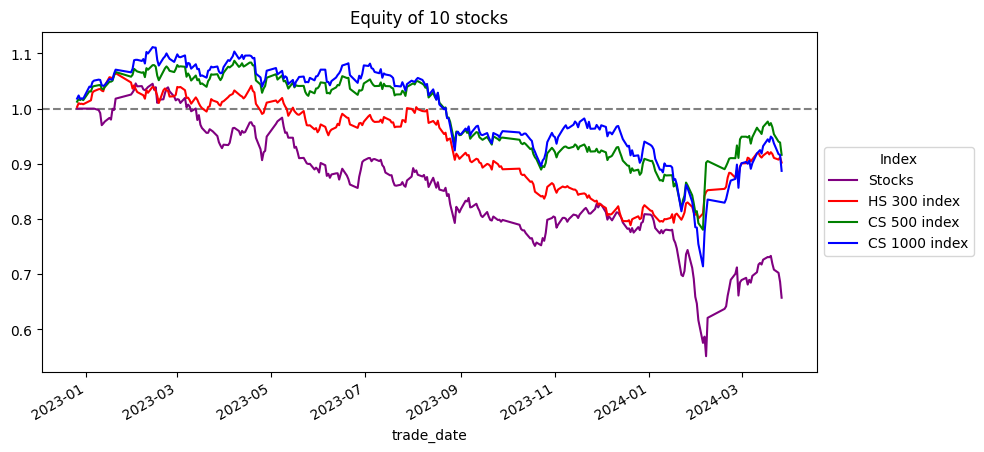

In [ ]:
def Simple_Backtest(factor_df, stock_num):
    # 简易版回测，选取靠前的n只股票回测，不计算分层收益
    
    factor_ranks = factor_df.rank(axis=1, ascending=False)
    # 取排名靠前的n只股票
    position_df = factor_ranks.apply(lambda x: x <= stock_num).astype(int)
    position_df = Ensure_position(position_df)

    del position_df["Monday"]
    stock_amount_sum = position_df.sum(axis=1)
    weight_allocation = position_df.apply(lambda x: x / stock_amount_sum, axis=0).fillna(0)
    profit = (weight_allocation * price_return_backtest).sum(axis=1)

    plt.rcParams['axes.unicode_minus'] = False # 正常显示负号
    plt.figure(figsize=(10, 5))
    plt.axhline(y=1, color='grey', linestyle='--')
    # Calculate the daily equity and draw.
    profit = profit.apply(lambda x: x + 1 if x == 0 else x + (1 - 0.0003))
    profit.cumprod().plot(label='Stocks', legend=True, color='#800080')

    profit_HS300 = HS_300_backtest.apply(lambda x: x + 1 if x == 0 else x + (1 - 0.0003))
    profit_HS300.cumprod().plot(label="HS 300 index", legend=True, color='r')
    profit_CS500 = CS_500_backtest.apply(lambda x: x + 1 if x == 0 else x + (1 - 0.0003))
    profit_CS500.cumprod().plot(label="CS 500 index", legend=True, color='g')
    profit_CS1000 = CS_1000_backtest.apply(lambda x: x + 1 if x == 0 else x + (1 - 0.0003))
    profit_CS1000.cumprod().plot(label="CS 1000 index", legend=True, color='b')

    plt.title(f"Equity of {stock_num} stocks")
    plt.legend(title='Index', bbox_to_anchor=(1, 0.5), loc='center left')
    plt.show()
Simple_Backtest(Ensemble_factor_df, 10)

### Ensemble Backtest

In [73]:
# Ensemble_factor_df_a = Ensemble_factor_df[Ensemble_factor_df.index >= '2023-07-01']

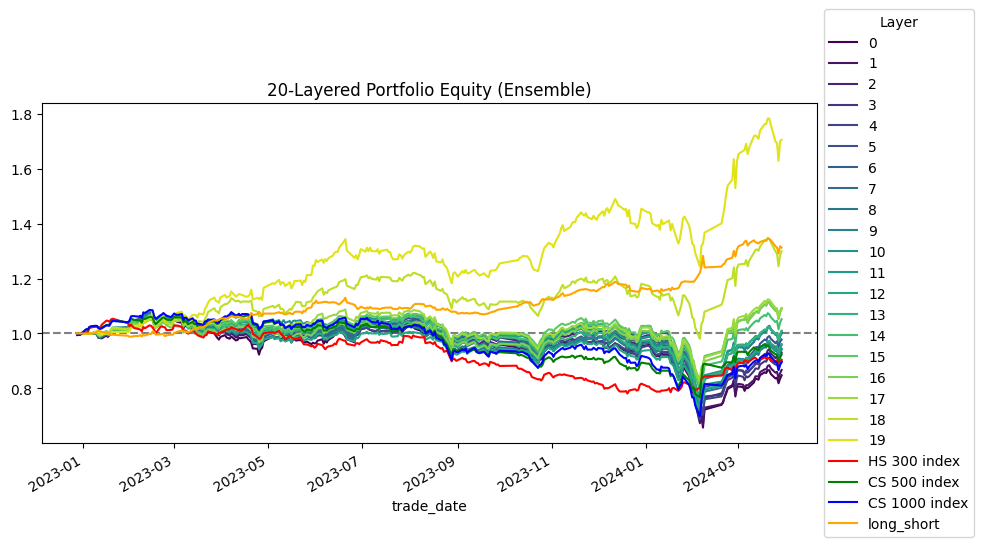

In [75]:
profit_long_Ensemble, Long_position_df_Ensemble = Layer_Backtest(Ensemble_factor_df, "Ensemble")

### MLP Backtest

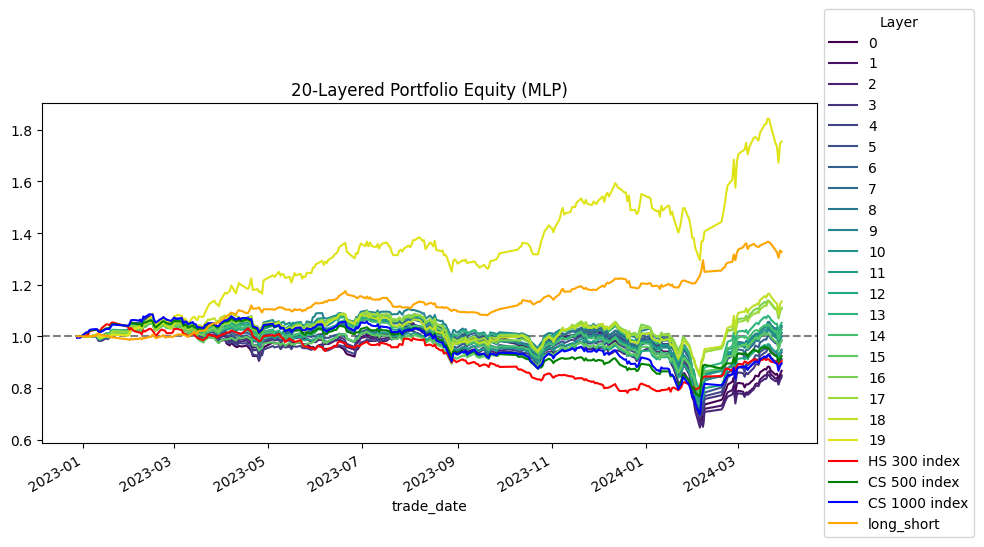

In [56]:
profit_long_MLP, Long_position_df_MLP = Layer_Backtest(MLP_factor_backtest, "MLP")

### GBDT Backtest

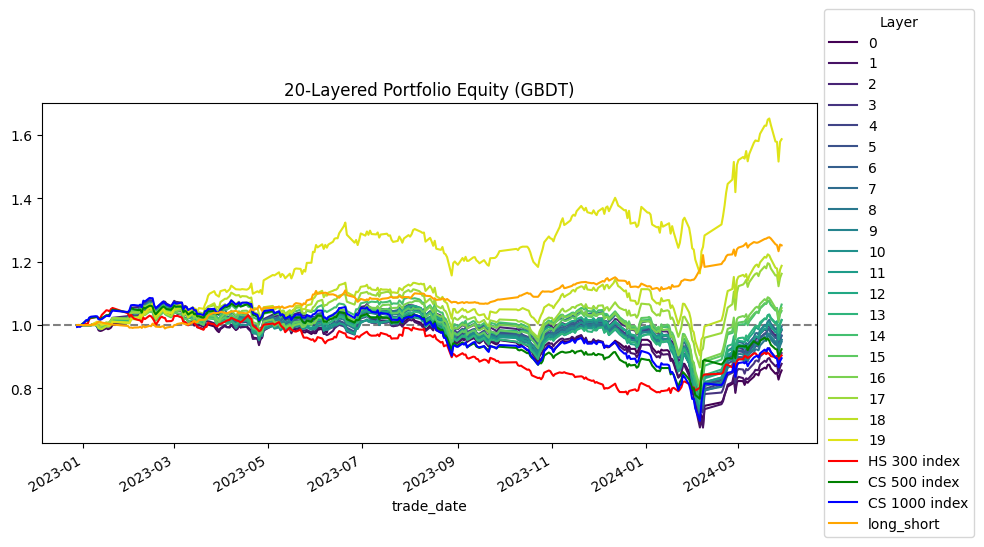

In [57]:
profit_long_GBDT, Long_position_df_GBDT = Layer_Backtest(GBDT_factor_backtest, "GBDT")

### AGRU Backtest

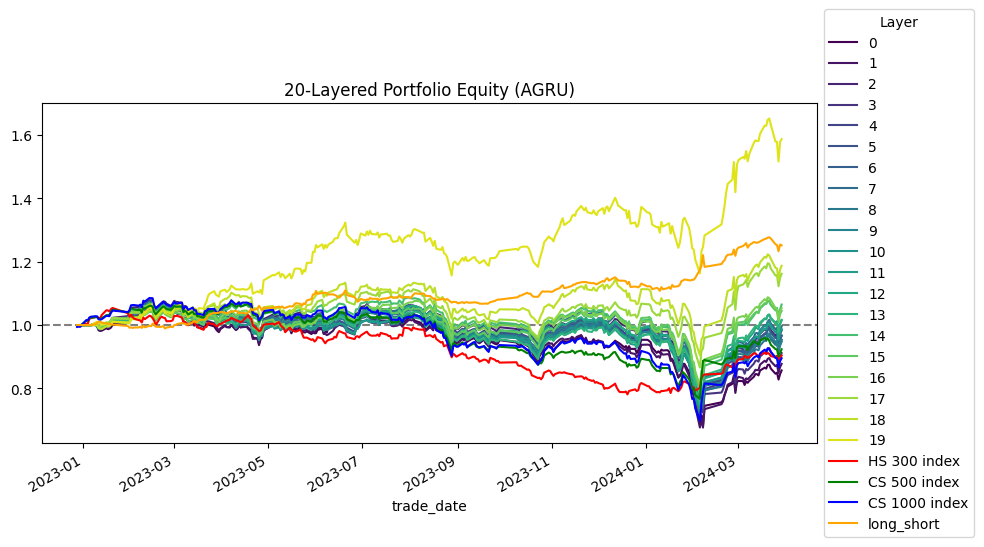

In [58]:
profit_long_AGRU, Long_position_df_AGRU = Layer_Backtest(GBDT_factor_backtest, "AGRU")

### 指标

1. RankIC mean(IC mean)
2. ICIR
3. IC winning rate
4. IC t-value
5. Long ROI
6. Long sharp
7. Long retracement
8. Long average weekly turnover rate

In [59]:
def Backtest_Indexes(factor_df, Profit_Long):
    # ICIR
    IC_series = factor_df.corrwith(price_return_backtest, 
                                   axis=1,
                                   method='spearman')
    IC_mean = IC_series.mean()
    print(f'IC mean: {IC_mean}')
    ICIR = IC_series.mean() / IC_series.std()
    print(f"ICIR: {ICIR}")
    IC_series.hist(bins=30)

    # IC winning rate，IC胜率
    IC_winning_rate = sum(1 for ic in IC_series if ic > 0) / len(IC_series)
    print(f"IC winning rate: {IC_winning_rate}")

    t_value = ICIR / sqrt(len(IC_series))
    print(f"IC t-value: {t_value}")

    # 多头收益
    Long_equity = Profit_Long * 2
    Long_ROI = (Long_equity[-1]) - 1
    print(f"Long ROI: {Long_ROI}")

    # Max Drawdown，最大回测
    # 计算峰值
    previous_peaks = Long_equity.cummax()
    # 计算回测
    drawdowns = (Long_equity - previous_peaks) / previous_peaks

    # 找到最大回撤及其相关日期
    # 将索引标签转换为数值格式
    drawdowns.index = pd.to_numeric(drawdowns.index)
    max_drawdown = drawdowns.min()
    print(f'Max drawdown: {max_drawdown}')
    max_drawdown_start = drawdowns.idxmin()

    # 如有需要，将开始日期和结束日期转换回原始格式
    max_drawdown_start = pd.to_datetime(max_drawdown_start).date()
    print(f"Max drawdown begin date: {max_drawdown_start}")

IC mean: -0.07534720597507473
ICIR: -0.7089473378795071
IC winning rate: 0.21782178217821782
IC t-value: -0.04072796040438463
Long ROI: 0.7054639899483954
Max drawdown: -0.16539219720009704
Max drawdown begin date: 2024-02-05


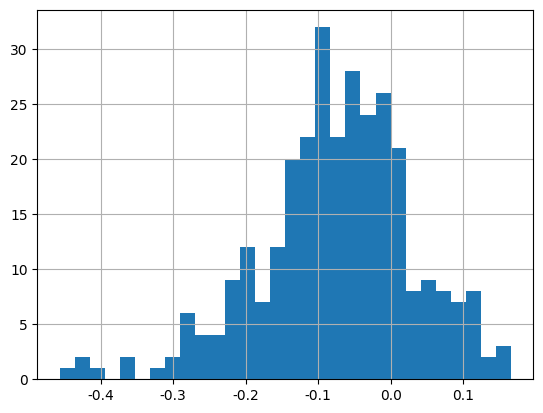

In [61]:
Backtest_Indexes(Ensemble_factor_df, profit_long_Ensemble)

IC mean: -0.08519608128228744
ICIR: -0.6271451358883675
IC winning rate: 0.23432343234323433
IC t-value: -0.03602854668819566
Long ROI: 0.7543593797868755
Max drawdown: -0.1873033587494744
Max drawdown begin date: 2024-02-05


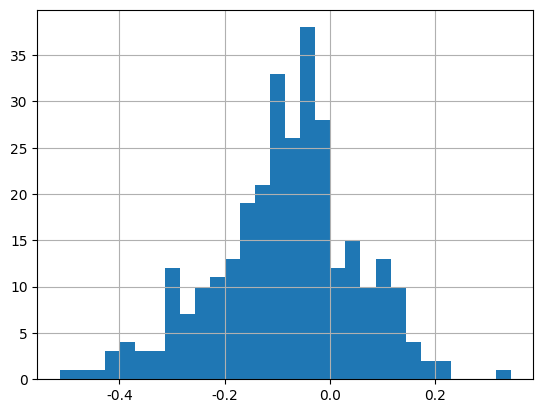

In [76]:
Backtest_Indexes(MLP_factor_backtest, profit_long_MLP)

IC mean: -0.06077960895297673
ICIR: -0.719159850900123
IC winning rate: 0.22112211221122113
IC t-value: -0.041314653948050346
Long ROI: 0.5868338250187899
Max drawdown: -0.17031489812272418
Max drawdown begin date: 2024-02-05


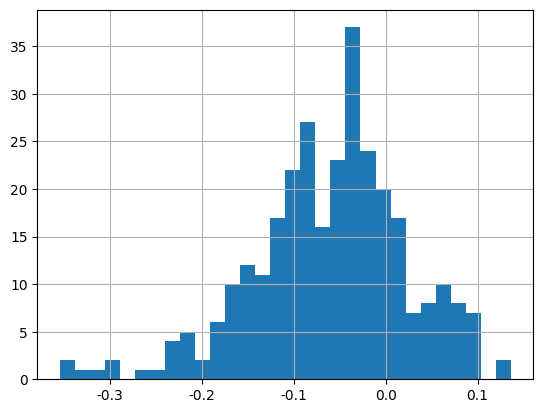

In [77]:
Backtest_Indexes(GBDT_factor_backtest, profit_long_GBDT)

IC mean: -0.06077960895297673
ICIR: -0.719159850900123
IC winning rate: 0.22112211221122113
IC t-value: -0.041314653948050346
Long ROI: 0.5868338250187899
Max drawdown: -0.17031489812272418
Max drawdown begin date: 2024-02-05


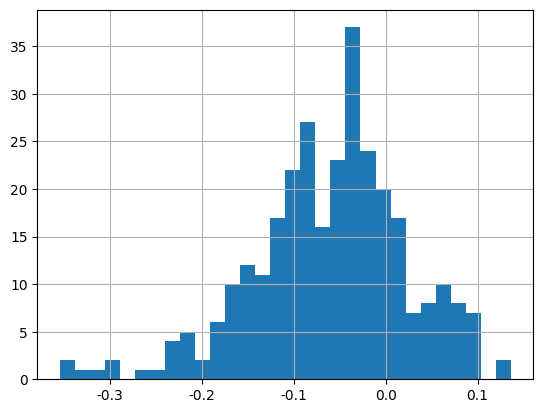

In [64]:
Backtest_Indexes(AGRU_factor_backtest, profit_long_AGRU)